# Inicializando

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import operator
import random

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import csr_matrix


base_path = ''
path_animes = '{}{}'.format(base_path, 'animes2.csv')
path_animelists = '{}{}'.format(base_path, 'animelists_cleaned2.csv')

Lendo as bases de dados

In [0]:
animes = pd.read_csv(path_animes, usecols=['anime_id', 'title'], dtype={'anime_id': 'int32', 'title': 'str'}, encoding='utf-16')
animelists = pd.read_csv(path_animelists, usecols=['username', 'anime_id', 'my_score'], dtype={'username': 'str', 'anime_id': 'int32', 'my_score': 'int32'})

In [3]:
animes

,anime_id,title
0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira
2,6,Trigun
3,7,Witch Hunter Robin
4,8,Bouken Ou Beet
...,...,...
6656,37886,Wo Shi Jiang Xiaobai (2018)
6657,37888,Tian Yu
6658,37894,Ling Yu 4th Season
6659,37895,Ling Yu 5th Season


In [4]:
animelists

,username,anime_id,my_score
0,karthiga,21,9
1,karthiga,59,7
2,karthiga,74,7
3,karthiga,120,7
4,karthiga,178,7
...,...,...,...
19134575,Hentai-Time,13221,9
19134576,Hentai-Time,11807,9
19134577,Hentai-Time,13937,10
19134578,Hentai-Time,14539,6


# Limpeza dos dados


Carregando os arquivos que precisam da limpeza

In [0]:
path_animes_old = "/content/drive/My Drive/Notebooks/animes.csv"
animes_old = pd.read_csv(path_animes_old, encoding='utf-16')

path_animelists_cleaned_old = "/content/drive/My Drive/Notebooks/animelists_cleaned.csv"
animelists_cleaned_old = pd.read_csv(path_animelists_cleaned_old, usecols=['username', 'anime_id', 'my_score', 'my_status'], dtype={'username': 'str', 'anime_id': 'int32', 'my_score': 'int32', 'my_status': 'int32'})

## Animes List

Inicializando o dicionario que conterá a contagem de pontuação de cada anime.

In [0]:
animes_count = {}
for index, row in animes_old.iterrows():
  animes_count[row['anime_id']] = 0

Contando quantidade de pontuação atribuída pelos usuários para cada anime.
Caso o *anime_id* da linha atual não possua um anime equivalente (da base *animes*) ele será excluido futuramente.

In [0]:
to_drop = []
for row in animelists_cleaned_old.itertuples():
  try:
    animes_count[row[2]] += 1
  except KeyError:
    to_drop.append(row[0])

Entradas de animes que precisam ser analisadas se seram ou não excluídas.

In [0]:
animes_id = []
for index in to_drop:
  if animelists_cleaned_old.iloc[index]['anime_id'] not in animes_id:
    animes_id.append(animelists_cleaned_old.iloc[index]['anime_id'])

animes_id

[36327, 12723, 37019, 37032, 34848, 32089, 37005]

Após analise dos animes, uma segunda lista foi gerada com aqueles que realmente podia ser excluídos. Os outros tiveram o anime_id trocado para um equivalente na base de animes.

In [0]:
drop = []
for index in to_drop:
  atual = animelists_cleaned_old.iloc[index]['anime_id']
  if atual == 36327:
    animelists_cleaned_old.at[index, 'anime_id'] = 36729
  elif atual == 12723:
    drop.append(index)
  elif atual == 37019:
    drop.append(index)
  elif atual == 37032:
    animelists_cleaned_old.at[index, 'anime_id'] = 36144
  elif atual == 34848:
    animelists_cleaned_old.at[index, 'anime_id'] = 32397
  elif atual == 32089:
    drop.append(index)
  elif atual == 37005:
    drop.append(index)
  

In [0]:
new_animelists = animelists_cleaned_old.drop(animelists_cleaned_old.index[drop])

Dropando as entradas que possuem *my_score* igual a 0, uma vez que a pontuação do MAL vai de 1 a 10.

In [0]:
score_0 = new_animelists[new_animelists['my_score'] == 0]

In [0]:
new_animelists = new_animelists.drop(score_0.index)

Dropando os usuário que avaliaram menos de 10 animes. Com fim de otimizar o código e evitar o *Cold Start* (em relação ao usuário).

In [0]:
user_count_score = pd.DataFrame(new_animelists.username.value_counts()).rename(columns={"username": "count"})
user_less_than_10_scores = user_count_score[user_count_score['count'] < 10]

new_animelists = new_animelists[~new_animelists['username'].isin(user_less_than_10_scores.index)]

Salvando a base de animes lists atualizada.

In [0]:
path_new_animelists_cleaned = "/content/drive/My Drive/Notebooks/animelists_cleaned2.csv"
new_animelists.to_csv(path_new_animelists_cleaned, index=None, header=True)

## Animes

Aqueles animes que não possuem pontuação atribuída por nenhum usuário podem ser apagados, já que não serão úteis nesse trabalho.

In [0]:
animes_id_no_review = []
for anime_id, count in animes_count.items():
    if count == 0:
      animes_id_no_review.append(anime_id)

In [0]:
drop = []
for row in animes_old.itertuples():
  if animes_count[row[1]] == 0:
    drop.append(row[0])

Salvando a base de animes atualizada.

In [0]:
new_animes = animes_old.drop(animes_old.index[drop])

path_new_animes = "/content/drive/My Drive/Notebooks/animes2.csv"
new_animes.to_csv(path_new_animes, index=None, header=True, encoding='utf-16')

# Vizualização dos dados

## Distribuição da quantidade de pontuação por anime_id


Plotam um gráfico com a quantidade de pontuação atribuída pelos usuários por *anime_id*.

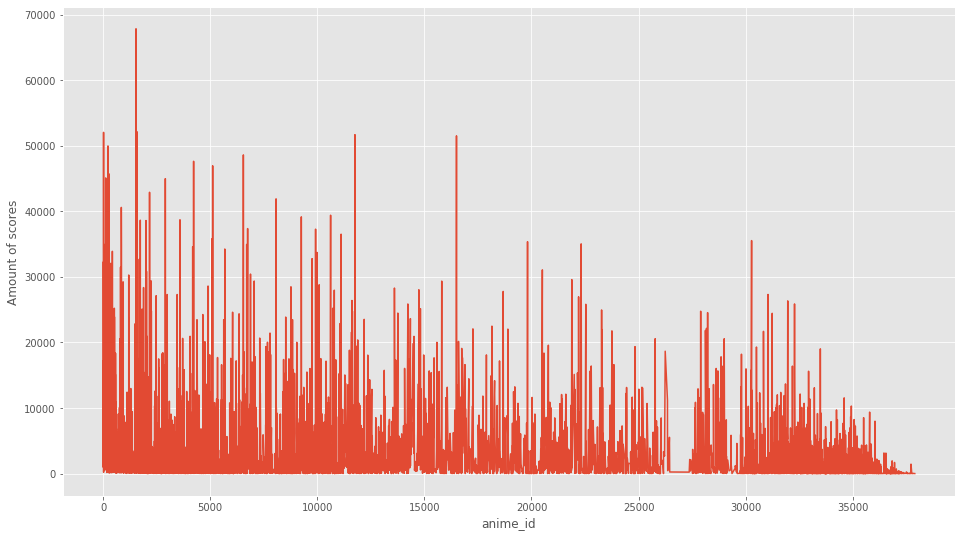

In [0]:
plt.rcParams['figure.figsize'] = (16, 9)

animes_count = {}
for index, row in animes.iterrows():
  animes_count[row['anime_id']] = 0

for row in animelists.itertuples():
    animes_count[row[2]] += 1

lists = sorted(animes_count.items()) # ordena pela chave, retorna tuplas

x, y = zip(*lists)

plt.style.use('ggplot')
plt.plot(x, y)
plt.xlabel('anime_id')
plt.ylabel('Amount of scores')
plt.show()

Plotando o gráfico que mostra a *long tail*.

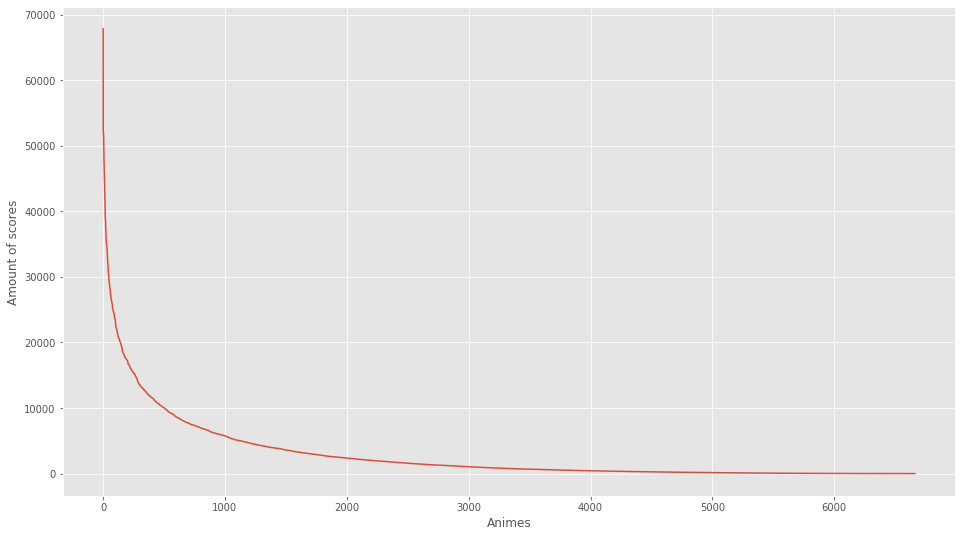

In [0]:
lists = sorted(animes_count.items(), key=operator.itemgetter(1), reverse=True)

x, y  = [], []
i = 1
for id, count in lists:
  x.append(i)
  y.append(count)
  i += 1

plt.style.use('ggplot')
plt.ylabel('Amount of scores')
plt.xlabel('Animes')
plt.plot(x, y)
plt.show()

## Quantidade de reviews

### Top 10

Top 10 animes com mais pontuação atribuída pelos usuários.

In [0]:
top_reviews = sorted(animes_count.items(), key=operator.itemgetter(1), reverse=True)[:10]
top_reviews_dict = dict(sorted(animes_count.items(), key=operator.itemgetter(1), reverse=True)[:10])
anime_id, reviews = zip(*top_reviews)

reviews_column = pd.Series([])

top_animes_review = animes.loc[animes['anime_id'].isin(anime_id)]
for index, row in top_animes_review.iterrows():
  reviews_column[index] = top_reviews_dict[row['anime_id']]

top_animes_review.insert(2, "scores", reviews_column)
top_animes_review.sort_values(by=['scores'], ascending=False)

,anime_id,title,scores
1101,1535,Death Note,67820
1133,1575,Code Geass: Hangyaku no Lelouch,52136
10,20,Naruto,52029
3541,11757,Sword Art Online,51676
3982,16498,Shingeki no Kyojin,51496
188,226,Elfen Lied,49957
2654,6547,Angel Beats!,48589
2218,4224,Toradora!,47619
2389,5114,Fullmetal Alchemist: Brotherhood,46929
229,269,Bleach,45706


# Sistema de recomendações

## K-mens

### Inicializando

Criando uma table onde cada linha representa um usuário, e as colunas representam os animes. Assim cada entrada será referente a pontuação atribuída pelo usuario daquela linha.

In [0]:
cross_table = animelists.reset_index().pivot_table(
    index='username',
    columns='anime_id',
    values='my_score'
).fillna(0)

PCA, algoritmo de redução de dimensionalidade. Ele ajuda no cálculo da *inertia*.

In [0]:
pca = PCA(n_components=3)
pca.fit(cross_table)
pca_samples = pd.DataFrame(pca.transform(cross_table))

In [0]:
tocluster = pd.DataFrame(pca_samples[[0,1,2]])

Plotando a representação gráfica do PCA antes da clusterização. 

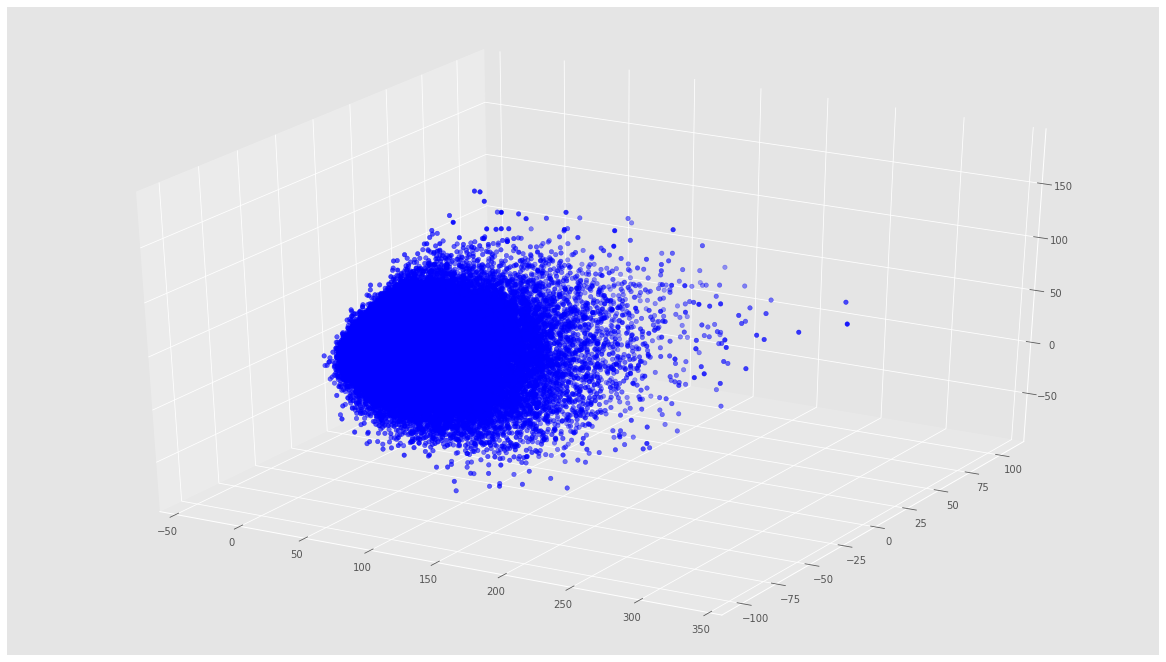

In [0]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c='blue')

plt.show()

### Escolhendo o K do K-means

Escolhendo o melhor valor para K do método K-means.

In [0]:
scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))

Gráfico do número de clusters por ***inertia***, que mede o quanto os clusters são coerentes internamente.

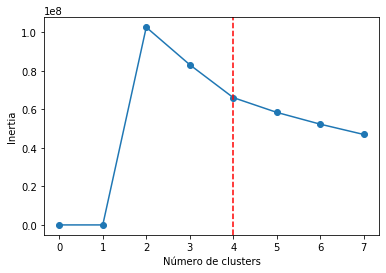

In [0]:
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Número de clusters')
plt.axvline(x=4, color='red', linestyle='--')
plt.ylabel('Inertia')
plt.show()

Gráfico do número de clusters pelo valor de ***Silhouette***, que mede quão bem os elementos estão classificados em seus clusters.

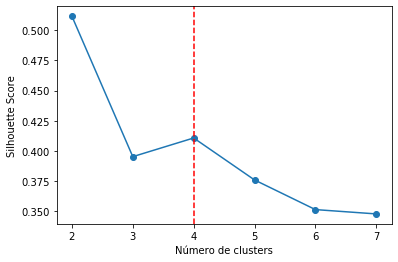

In [0]:
plt.plot(range(2,8), scores, '-o');
plt.xlabel('Número de clusters');
plt.axvline(x=4, color='red', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

### Execução do K-means


Calculando o K-mens e os respectivos clusters.

In [0]:
clusterer = KMeans(n_clusters=4,random_state=30,).fit(tocluster)
c_preds = clusterer.predict(tocluster)

Obtendo os centros de cada cluster.

In [0]:
centers = clusterer.cluster_centers_

Clusters em 3D, no mesmo formato do PCA.

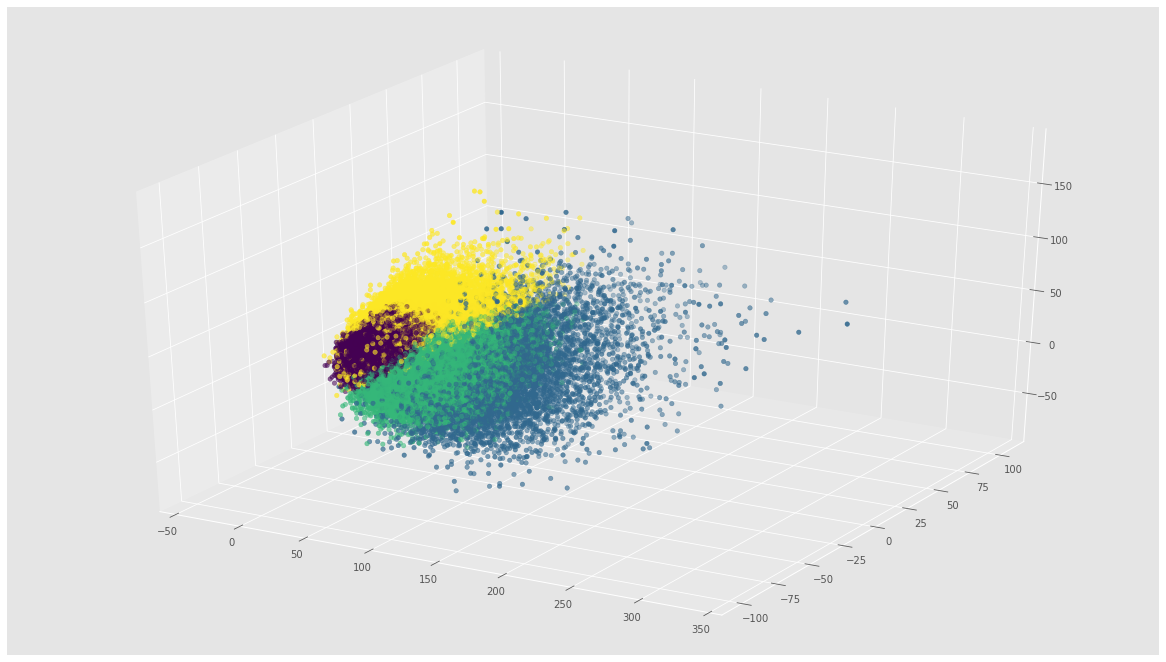

In [0]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.show()

Clusters em 2D, com seus respectivos centros.

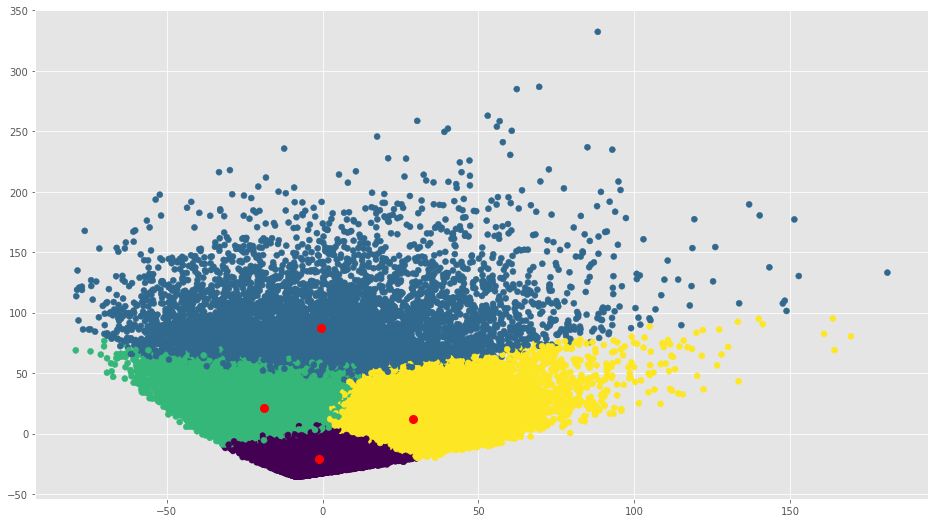

In [0]:
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.show()

### Criando os clusters

Adicionando uma coluna na tabela que repsenta de qual cluster aquele usuário pertence.

In [0]:
cross_table['cluster'] = c_preds

Montando efetivamente os clusters.

In [0]:
clusters = [cross_table[cross_table['cluster']==0].drop('cluster',axis=1), 
            cross_table[cross_table['cluster']==1].drop('cluster',axis=1),
            cross_table[cross_table['cluster']==2].drop('cluster',axis=1),
            cross_table[cross_table['cluster']==3].drop('cluster',axis=1)]

Limpando as columas que possuem apenas zeros.

In [0]:
clusters[0].drop(clusters[0].loc[:, (clusters[0] == 0).all()].columns, axis = 1, inplace = True)
clusters[1].drop(clusters[1].loc[:, (clusters[1] == 0).all()].columns, axis = 1, inplace = True)
clusters[2].drop(clusters[2].loc[:, (clusters[2] == 0).all()].columns, axis = 1, inplace = True)
clusters[3].drop(clusters[3].loc[:, (clusters[3] == 0).all()].columns, axis = 1, inplace = True)

## Criando as recomendações

Funções úteis.

In [0]:
# pega o nome de um anime dado seu anime_id.
def get_anime(anime_id):
  return animes.loc[animes['anime_id'] == anime_id].iloc[0]['title']

# pega a pontuação atribuida por um usuário a um dado anime_id
def get_user_score_by_anime(user, anime_id):
  return cross_table.loc[user, anime_id]

# pega os aimes já pontuados por um usuário
def get_watched_animes(user):
  return animelists.loc[animelists['username'] == user]['anime_id'].tolist()

# pega o cluster de um usuário
def user_in_cluster(user):
  for idx in range(len(clusters)):
    if user in clusters[idx].index:
      return idx

  raise Exception('User unknow')

Sistema de recomendações de animes!

In [0]:
class recommender_system:
  def __init__(self, k=10, u=None, exclude_scored_by_user=True, user=None):
    self.k = k

    self.u = u
    if not self.u:
       self.u = k if k > 10 else 10
  
    self.exclude_scored_by_user = exclude_scored_by_user
    self.cluster = None
    self.scored_by_user = None
    self.user_similarity_df = None

    self.user = user
    if self.user:
      self.__init_by_user(self.user)

  # Inicializando váriaveis referetentes ao usuário
  def __init_by_user(self, user):
    self.user = user
    self.cluster = user_in_cluster(self.user)
    self.__user_similarity()
    self.scored_by_user = get_watched_animes(self.user)
  
  # Obtendo a similaridade de um dado usuário para com todos os outros usuários do seu cluster.
  def __user_similarity(self):
    sim = cosine_similarity(clusters[self.cluster].loc[self.user].values.reshape(1, -1), clusters[self.cluster])
    self.user_similarity_df = pd.DataFrame(sim, index=[self.user], columns=clusters[self.cluster].index)

  # Montando uma lista dos K animes melhor pontuados pelos usuários mais similares.
  def user_similar_recs(self):

    sim_users = self.user_similarity_df.sort_values(by=self.user, ascending=False, axis=1).columns[1:(self.u + 1)]

    best = []
    most_common = {}
    
    for i in sim_users:
        max_score = clusters[self.cluster].loc[i, :].max()
        best.append(clusters[self.cluster].loc[i, clusters[self.cluster].loc[i, :]==max_score].index.tolist())

    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1

    if self.scored_by_user:
      for key in self.scored_by_user:
        most_common.pop(key, None)

    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:self.k]

  # Prediz a pontuação a ser atribuida pelo usuário a dado anime.
  def predicted_rating(self, anime_id):

    sim_users = self.user_similarity_df.sort_values(by=self.user, ascending=False, axis=1).columns
    sim_value = self.user_similarity_df.sort_values(by=self.user, ascending=False, axis=1).values[0]

    count = sum_sim = sum_ratings = 0
    for j, i in enumerate(sim_users):
      rating = get_user_score_by_anime(i, anime_id)
      sim = sim_value[j]

      if rating == 0:
        continue
      else:
        count += 1
        sum_sim += sim
        sum_ratings += sim * rating
      
      if count == self.u:
        break

    try:
      return sum_ratings / sum_sim
    except ZeroDivisionError:
      return 0

  # Criando as recomendações.
  def recommendations(self, user=None, users_similar=True):
    if user:
      self.__init_by_user(user)
    
    if users_similar:
      similar = self.user_similar_recs()
      animes_to_estimate = [i[0] for i in similar]
    else:
      # estimate all animes
      animes_to_estimate = set(cross_table.columns.to_list())

      if self.exclude_scored_by_user:
        animes_to_estimate = animes_to_estimate - set(self.scored_by_user)

    predict = {}
    for anime_id in animes_to_estimate:
      predict[anime_id] = self.predicted_rating(anime_id)

    sorted_list = sorted(predict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:self.k]

  def set_u(self, u):
    self.u = u

  # MSE & RMSE & MAE
  def mse_rmse_mae(self):
    errors_mse = []
    errors_mae = []
    for anime_id in self.scored_by_user:
        actual = get_user_score_by_anime(self.user, anime_id)
        predicted = self.predicted_rating(anime_id)
        errors_mse.append((actual - predicted) ** 2)
        errors_mae.append(abs(actual - predicted))

    len_scores = 1 / len(self.scored_by_user)
    mse = len_scores * np.sum(errors_mse)
    rmse = mse ** (1 / 2)
    mae = len_scores * np.sum(errors_mae)
    return mse, rmse, mae

Exibindo as recomendações para um usuário qualquer.

In [0]:
users = pd.DataFrame(animelists.username.value_counts()).index.to_list()

In [82]:
user_name = random.choice(users)

rs = recommender_system(k=10, u=10)
recommends = rs.recommendations(user_name)

df_recommends = pd.DataFrame(recommends, columns=['Anime', 'Pontuação estimada']).style.format({'Anime': get_anime})

print('Recomendações para {}: '.format(user_name))
df_recommends

Recomendações para toma-niisan: 


,Anime,Pontuação estimada
0,Koe no Katachi,9.60603
1,Boku dake ga Inai Machi,9.51583
2,Boku no Hero Academia 2nd Season,9.31803
3,Kiseijuu: Sei no Kakuritsu,9.12533
4,Fullmetal Alchemist: Brotherhood,9.03221
5,Hunter x Hunter (2011),9.00163
6,High School DxD BorN,8.43359
7,High School DxD Specials,8.2658
8,Ao no Exorcist,7.85434
9,B-gata H-kei,5.98693


In [83]:
errors = rs.mse_rmse_mae()
print('RMSE: {}; MAE: {}'.format(errors[1], errors[2]))

RMSE: 1.248599651500226; MAE: 1.0453142841519256


### Analisando o valor de *u*

In [0]:
rs = random.choice(users)

mse = []
rmse = []
mae = []
for i in range(10, 50):
  rs.set_u(i)
  result = rs.mse_rmse_mae()
  mse.append(result[0])
  rmse.append(result[1])
  mae.append(result[2])

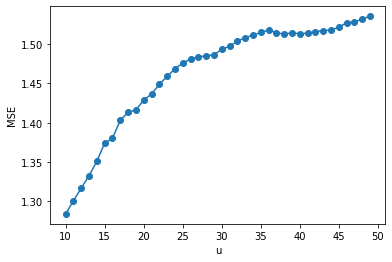

In [0]:
plt.plot(range(10, 50), mse, '-o')
plt.xlabel('u')
plt.ylabel('MSE')
plt.show()

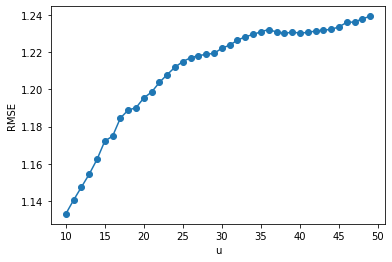

In [0]:
plt.plot(range(10, 50), rmse, '-o')
plt.xlabel('u')
plt.ylabel('RMSE')
plt.show()

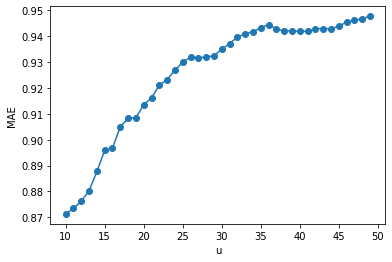

In [0]:
plt.plot(range(10, 50), mae, '-o')
plt.xlabel('u')
plt.ylabel('MAE')
plt.show()

### Métrica de relevância das recomendações

In [0]:
count = mse = rmse = mae = 0

In [0]:
for u in clusters[1].index:
  rs = recommender_system(user=u, u=10)
  result = rs.mse_rmse_mae()
  mse += result[0]
  rmse += result[1]
  mae += result[2]
  count += 1

In [39]:
rmse / count

1.140346896343758

In [40]:
mae / count

0.9154014426502346

## Armazenando os clusters

In [0]:
cross_table.to_pickle('{}{}'.format(base_path, 'cross_table.pkl'))

In [0]:
clusters[0].to_pickle('{}{}'.format(base_path, 'cluster1.pkl'))
clusters[1].to_pickle('{}{}'.format(base_path, 'cluster2.pkl'))
clusters[2].to_pickle('{}{}'.format(base_path, 'cluster3.pkl'))
clusters[3].to_pickle('{}{}'.format(base_path, 'cluster4.pkl'))

## Carregando os clusters

In [0]:
clusters = [None, None, None, None]

In [0]:
cross_table = pd.read_pickle('{}{}'.format(base_path, 'cross_table.pkl'))

In [0]:
clusters[0] = pd.read_pickle('{}{}'.format(base_path, 'cluster1.pkl'))
clusters[1] = pd.read_pickle('{}{}'.format(base_path, 'cluster2.pkl'))
clusters[2] = pd.read_pickle('{}{}'.format(base_path, 'cluster3.pkl'))
clusters[3] = pd.read_pickle('{}{}'.format(base_path, 'cluster4.pkl'))